Summary of the Keras learning:
1. CV
2. NLP
3. Structured Data
4. Time Series
5. GDL
6. Reinforcement
7. Quick recipes

1. CV

2. NLP
2.1. Text classification from scratch

IMDB movie review sentiment classification
curl command download -> split the data for train/val, read in test data -> remove html tag <br /> ->
Vectorize text, vectorize_layer (normalize, split, and map strings to integers) -> 
option I: accept string input, then add vectorize layer in the model after input layer -> layer embedding
option II: apply integer sequences on input data (asynchronous CPU processing) -> prefetching / buffering
build model: layers (Input -> Embedding max_feature/embedding dim -> Dropout 0.5 -> Conv1D filter=128, kernel=7, padding=valid, activation=relu, strides=3 -> Conv1D 128,7,valid,relu,3 -> GlobalMaxPolling1D -> Dense 128, relu -> Dropout 0.5, -> Dense 1, sigmoid) -> complie binarycrossentropy, adam, accuracy -> fit -> evaluate(test_ds)

Use option I: end (string input) to end (string output) model


2.2. Sequence to sequence learning for performing number addition
A model that learns to add strings of numbers, e.g. "535+61" -> "596". 
Set Reverse=true, 3 digits -> utility functions (one-hot integer for encode, decode) -> random generate/dedup/reverse query -> input question -> vectorize the data by calling encode func -> shuffle -> split train/val data
build model:  Sequential() -> layers (LSTM 128, RepeatVector, one or multiple LSTM 128, Dense softmax -> compile (categorical crossentropy, adam, accuracy) -> fit -> predict (10 random samples)



2.3. Bidirectional LSTM on IMDB
Train a 2-layer bidirectional LSTM on the IMDB movie review sentiment classification dataset.

Build model: Input, Embedding 128, Bidirectional LSTM 64, Bidirectional LSTM 64, Dense 1 sigmoid
keras internal loader to load dataset -> train/val 
model compile (binary crossentropy, adam, accuracy) -> fit (train/val, batch size, epochs)


2.4. Character-level recurrent sequence-to-sequence model
recurrent sequence-to-sequence model: English => French
curl download zip file -> unzip -> Vectorize the data -> sort input/target chars -> dict => encoder/deconder -> input np.zeros -> tokenize input/target texts
Build model: Input, layers (LSTM latent_dim, Dense num_decoder_tokens softmax) -> complie (optimizer=rmsprop, categorical_crossentropy, accuracy) -> fit -> save model


    Inference: Use the model to learn about the data generation process.
    Prediction: Use the model to predict the outcomes for new data points.

Inference/Sampling -> load_model -> assemble encoder model (encoder_inputs, encoder_states)) -> assemble decorder model ([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
create decode sequence utility (encoder model predict -> state_value -> (loop through) -> decoder model predict -> state_value -> (loop through) )
call decode sequence utility to translate the samples


2.5. Using pre-trained word embeddings
We'll work with the Newsgroup20 dataset, a set of 20,000 message board messages belonging to 20 different topic categories.

For the pre-trained word embeddings, we'll use GloVe embeddings.
https://nlp.stanford.edu/projects/glove/

url download gz file and untar -> list directory and file counts -> open file and read contents -> remove the 10 head lines of file to remove the leaking category info -> shuffle data and split train/val -> TextVectorization he vocabulary -> dict(zip(voc, range(len()))) to index the vocabulary

weget pre-trained GloVe embeddings zip -> unzip -> use 100-dimensional -> prepare embedding matrix -> load matrix to Embedding layer

Build model: Input -> layers (embedding layer, Conv1D 128 5 relu, MaxPolling1D 5, Conv1D 128 5 relu, MaxPolling1D 5, Conv1D 128 5 relu, GlobalMaxPolling, Dense 138 relu, Dropout 0.5, Dense 20 (# of class/categories) softmax -> summary

train/val string -> convert our list-of-strings data to NumPy arrays of integer indices -> train/val int
model compile (sparse categorial crossentropy, rmsprop, acc -> fit

optimizor RMSprop:
The RMSprop optimizer is similar to the gradient descent algorithm with momentum. The RMSprop optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster. 
This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding, and increasing the step for small gradients to avoid vanishing.

Export an end-to-end model:
want to export a Model object that takes as input a string of arbitrary length, rather than a sequence of indices. 
string input -> vectorizer -> int -> model(int) -> keras.Model(string input, model(int)) -> end_to_end_model -> predict(words)

2.6. Text classification with Transformer
Implement a Transformer block as a Keras layer and use it for text classification.

MultiHeadSelfAttention: (projection_dim = embed_dim // num_head, query dense, key dense, value dense, combine head)
attention (score, weights, output)
separate_heads (reshape, transpose)

Call (batch_size Input -> query, key,value -> separate_heads(query,key,value) -> attention, weights -> transpose attention -> reshape concat_attention -> combine_heads output)

TransformerBlock: Sequential -> layer (Dense ff_dim relu, Dense embed_dim, LayerNormalization1, LayerNormalization2, Dropout1, Dropout2

ff* - feed forward

Call (attention inputs, Dropout1, Norm1, Dense ffn, Dropout2, Norm2 (output from Norm1 + output from Dense ffn) )

Two separate embedding layers: tokens, token index

Download train/val from kearas.datasets.imdb.load_data

create classifier model takes the mean across all time steps and uses a feed forward network - TokenAndPositionEmbedding -> embedding_layer -> transformer block -> GlobalAveragePooling1D, Dropout 0.1, Dense 20 relu, Dropout 0.1, Dense 2 softmax -> compile (adam, sparse_categorical_crossentropy, accuracy) -> fit

2.7. BERT (from HuggingFace Transformers) for Text Extraction
Fine tune pretrained BERT from HuggingFace Transformers on SQuAD.
BERT - Bidirectional Encoder Representations from Transformers

save the slow pretrained Bertokenizer -> load the fast tokenizer from saved file
load data from url keras.utils.get_file -> train/val (SQuAD Standford Question-Answer Dataset)
parse json -> create SquadExample: tokenizer context, question, answers (start and end) -> create input -> pad and create attention masks
Build model: Input -> Input token_type -> Input attention mask -> embedding -> Dense 1 start_logit -> Flatten(start_logit) -> Dense 1 end_logit -> Flatten (end_logit) -> Activation (start_logit) -> Activation (end_logit) -> input (Input, Input token_type, Input attention mask), outputs (start_logit, end_logit)
loss (SparseCategoricalCrossentropy), optimizer Adam, compile

use Google Colab TPU (Tensor Process Unit): create distribution strategy -> create model
create evaluation callback: 
normalize text (lower(), remove punctuations, remove a, an, the, remove extra white space)
convert predicted start-end back to strings, and compute the accuracy by counting the percentage of chars matched
model fit -> compute the acc by calling the evaluation callback -> check the result

3. Structured Data
3.1. Structured data classification from scratch
Cleveland Clinic Foundation for Heart Disease.
read csv -> split train/val -> dataframe => dataset (batched)
normalize numerical feature
encode string categorical feature => StringLookup => encode integer categorical feature
encode integer categorical feature
build model: input encoded -> layers (Dense 32 relu, Dropout 0.5, Dense 1 sigmoid) -> compile (binarycrossentropy, adam, accuracy) -> fit -> predict

3.2. Collaborative Filtering for Movie Recommendations
Recommending movies using a model trained on Movielens dataset.
url download zip file -> unzip -> encode as integer indices -> split train/val dataframe
Net: layers (Embedding/he_normal (user + bias, movie + bias) -> tensordot -> nn.sigmoid -> compile (binarycrossentropy, adam) -> fit -> draw loss vs. epoch -> predict -> flatten


3.3. Imbalanced classification: credit card fraud detection
This example looks at the Kaggle Credit Card Fraud Detection dataset to demonstrate how to train a classification model on data with highly imbalanced classes.
manual download -> split feature/label -> split train/val -> compute imbalance weights -> normalize features (-mean/std)
Build model: layers (Dense 256 relu, Dropout 0.3, Dense 256 relu, Dropout, 0.3, Dense 1 sigmoid) ->
compile (binarycrossentropy, adam, lr 0.001, confusion metrics) -> callbacks modelcheckpoint -> class wieght -> fit

4. Time Series
4.1. Timeseries anomaly detection using an Autoencoder
use the Numenta Anomaly Benchmark(NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. To demonstrate anomaly detection effectively.

read csv files (url path, noises and jumps) -> plot to visualize data 

noises/train data -> normalize (-mean/std) -> use TIMESTEP to create conv sequence

build model: layers (Conv1D 32,7,same,2,relu filter/kernel/padding/strides/act, Dropout 0.2, Conv1D 16,7,same,2,relu, Conv1DTranspose 16,7,same,2,relu, Dropout 0.2, Conv1DTranspose 32,7,same,2,relu, Conv1DTranspose 1,7,same) -> compile (adam la 0.001, loss=mse) -> summary -> fit (use train data on both input & target, callback EarlyStopping) -> plot history(loss) -> predict(train data) -> get MAE loss -> threshold = np.max(train_mae_loss)

jumps/test data -> normalize (-mean/std) -> use TIMESTEP to create sequence -> predict(test data) -> get MAE loss -> anomalies = (test_mae_loss > threshold).tolist() -> plot anomalies

* Transposed convolution is generally used in backward pass. It is called transposed because of the analogy with fully connected layer where you multiply with the transpose of the weight matrix during a backward pass. 


In [2]:
import pandas
import arcgis

/Users/lcao@us.ibm.com/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/_data/geodataset/utils.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


In [3]:
print(pandas.__version__)
print(arcgis.__version__)

1.0.1
1.6.0


In [4]:
import ipywidgets
print(ipywidgets.__version__)
import widgetsnbextension
print(widgetsnbextension.__version__)

7.5.1
3.5.1


In [5]:
!jupyter nbextension list

Known nbextensions:
  config dir: /Users/lcao@us.ibm.com/.jupyter/nbconfig
    notebook section
      jupyter-js-widgets/extension  enabled 
      - Validating: OK
  config dir: /Users/lcao@us.ibm.com/opt/anaconda3/etc/jupyter/nbconfig
    notebook section
      jupyter-js-widgets/extension  enabled 
      - Validating: OK
      arcgis/extension  enabled 
      - Validating: OK


In [6]:
from arcgis.gis import GIS
gis = GIS()
map1 = gis.map()
map1

MapView(layout=Layout(height='400px', width='100%'))

In [13]:
import networkx as nx
import matplotlib.pyplot as plt


In [14]:
g = nx.Graph()
g.add_edge(2,5)
g.add_edge(4,1)
g.add_edge(5,1)
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 3
Average degree:   1.5000


In [17]:
from operator import itemgetter
n, m = 1000, 2
G = nx.generators.barabasi_albert_graph(n, m)


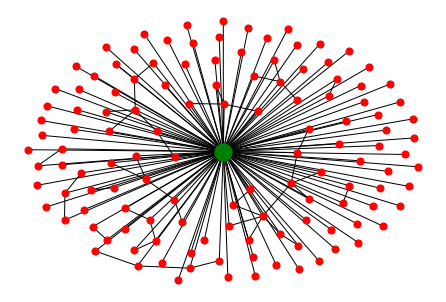

Name: 
Type: Graph
Number of nodes: 127
Number of edges: 167
Average degree:   2.6299


In [29]:
#locate node with largest degree
node_and_degree = G.degree()
#type(dict(node_and_degree).items())
(largest_hub, degree) = sorted(dict(node_and_degree).items(), key=itemgetter(1))[-1]
#create ego graph
hub_ego = nx.ego_graph(G, largest_hub)
#draw the ego graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color='r', node_size=50, with_labels=False)
#daw ego node as large and green
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='g')
plt.show()
print(nx.info(hub_ego))

In [30]:
from bs4 import BeautifulSoup
import requests

In [32]:
r  = requests.get("https://github.com")
print(r.url)
#r.content

https://github.com/


In [33]:
r.encoding

'utf-8'

In [34]:
with open("/Users/lcao@us.ibm.com/Downloads/testsoup", "wb") as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

In [36]:
tfile = open("/Users/lcao@us.ibm.com/Downloads/testsoup", "r")
soup = BeautifulSoup(tfile, "html.parser")
ghText = soup.get_text()
#print(ghText)

In [37]:
soup.title

<title>The world’s leading software development platform · GitHub</title>

In [51]:
#soup.head
#soup.find_all("html")
import re
soup.find_all(href=re.compile("project\-management"))

[<a class="py-2 lh-condensed-ultra d-block link-gray no-underline f5" data-ga-click="(Logged out) Header, go to Project management" href="/features/project-management/">Project management</a>,
 <a class="summarylink" href="/features/project-management">
 <div class="summarylink-illustration">
 <img alt="" class="width-fit mx-auto" loading="lazy" src="https://github.githubassets.com/images/modules/site/home/team-chaos.svg"/>
 </div>
 <div class="summarylink-btn d-flex flex-justify-between flex-items-center f5 text-gray-dark rounded-1 p-sm-4 my-4 my-sm-0">
 <div class="col-10">
 <h3 class="h3-mktg text-normal mb-1">Manage your chaos</h3>
 <p class="mb-0">Take a deep breath. On GitHub, project management happens in issues and project boards, right alongside your code. All you have to do is mention a teammate to get them involved. <span class="link-mktg text-blue">Learn about project management.</span></p>
 </div>
 <svg aria-hidden="true" class="octicon octicon-triangle-right text-blue" he

In [53]:
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize


In [54]:
testT = "After months of living with the coronavirus pandemic, American citizens are well aware of the toll it has taken on the economy: broken supply chains, record unemployment, failing small businesses. All of these factors are serious and could mire the United States in a deep, prolonged recession. But there’s another threat to the economy, too. It lurks on the balance sheets of the big banks, and it could be cataclysmic. Imagine if, in addition to all the uncertainty surrounding the pandemic, you woke up one morning to find that the financial sector had collapsed."
print(sent_tokenize(testT))

['After months of living with the coronavirus pandemic, American citizens are well aware of the toll it has taken on the economy: broken supply chains, record unemployment, failing small businesses.', 'All of these factors are serious and could mire the United States in a deep, prolonged recession.', 'But there’s another threat to the economy, too.', 'It lurks on the balance sheets of the big banks, and it could be cataclysmic.', 'Imagine if, in addition to all the uncertainty surrounding the pandemic, you woke up one morning to find that the financial sector had collapsed.']


In [55]:
print(word_tokenize(testT))

['After', 'months', 'of', 'living', 'with', 'the', 'coronavirus', 'pandemic', ',', 'American', 'citizens', 'are', 'well', 'aware', 'of', 'the', 'toll', 'it', 'has', 'taken', 'on', 'the', 'economy', ':', 'broken', 'supply', 'chains', ',', 'record', 'unemployment', ',', 'failing', 'small', 'businesses', '.', 'All', 'of', 'these', 'factors', 'are', 'serious', 'and', 'could', 'mire', 'the', 'United', 'States', 'in', 'a', 'deep', ',', 'prolonged', 'recession', '.', 'But', 'there', '’', 's', 'another', 'threat', 'to', 'the', 'economy', ',', 'too', '.', 'It', 'lurks', 'on', 'the', 'balance', 'sheets', 'of', 'the', 'big', 'banks', ',', 'and', 'it', 'could', 'be', 'cataclysmic', '.', 'Imagine', 'if', ',', 'in', 'addition', 'to', 'all', 'the', 'uncertainty', 'surrounding', 'the', 'pandemic', ',', 'you', 'woke', 'up', 'one', 'morning', 'to', 'find', 'that', 'the', 'financial', 'sector', 'had', 'collapsed', '.']


In [56]:
word_tokenize(testT).count("the")

10

In [61]:
from __future__ import print_function
import sys

In [67]:
%%capture myCap
print("hello frank")

In [70]:
myCap
myCap()

hello frank


In [71]:
%%capture myCap
print("This is a standard output")
print("That is a standard error", file=sys.stderr)


In [74]:
myCap()
myCap.stdout
#myCap.stderr

This is a standard output


That is a standard error


'This is a standard output\n'

In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
%%capture myCap1
print("building x-axis data points...")
x = np.linspace(0,5,300)
print("building y-axis data points")
y = np.cos(x)
print("performing plot and labeling axis")
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('cos(x)')
print("disply plot now...")
plt.show()

building x-axis data points...
building y-axis data points
performing plot and labeling axis
disply plot now...


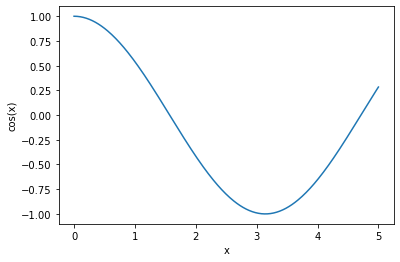

In [79]:
myCap1()

This article is for folks who want to know the intuition behind determining the order of auto-regressive (AR) and moving average (MA) series using ACF and PACF plots. Most of us know how to use ACF and PACF plots to obtain the values of p and q to feed into the AR-I-MA model, but we lack the intuition behind why we use PACF and ACF to obtain p and q respectively and not the other way around.
Let’s understand what do we mean by ACF and PACF first,
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.
PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.
Now let’s see what is an AR and MA time series process,
Auto regressive (AR) process , a time series is said to be AR when present value of the time series can be obtained using previous values of the same time series i.e the present value is weighted average of its past values. Stock prices and global temperature rise can be thought of as an AR processes.
The AR process of an order p can be written as,
ŷt   =   c + ϕ1 yt-1 + ϕ2 yt-2 + … + ϕp yt-p + ϵt
Where ϵt is a white noise and y’t-₁ and y’t-₂ are the lags. Order p is the lag value after which PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series. We cannot use the ACF plot here because it will show good correlations even for the lags which are far in the past. If we consider those many features, we will have multicollinearity issues.This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.
In the below code, I have defined a simple AR process and found its order using the PACF plot. We should expect our AR process to show gradual decrease in the ACF plot since being an AR process its present has good correlation with the past lags. We expect PACF to have sharp fall after near lags as these lags near to present can capture the variation so well that we don’t need past lags to predict present.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

In [90]:
t = np.linspace(0, 10, 500)
#normal distributed values
ys = np.random.normal(0,5,500)

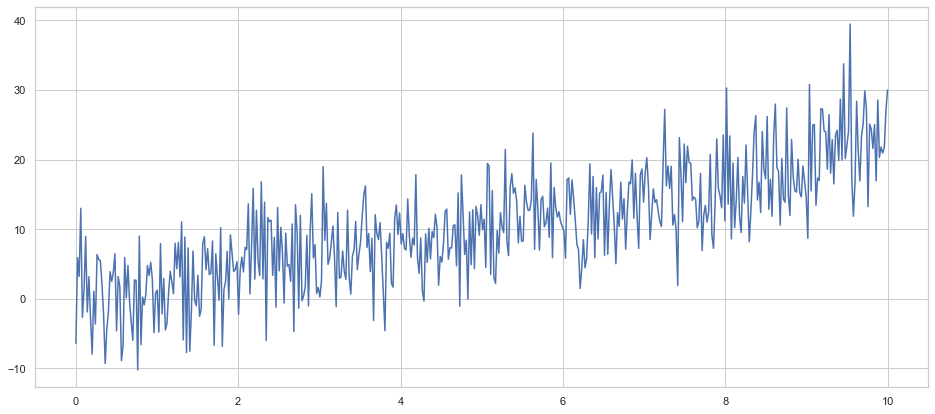

In [91]:
#exponential series to get the trend
ye = np.exp(t**0.5)
#adding normally distributed series in exponential series
y = ys+ye
#plot
plt.figure(figsize=(16,7))
plt.plot(t,y)

/Users/lcao@us.ibm.com/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


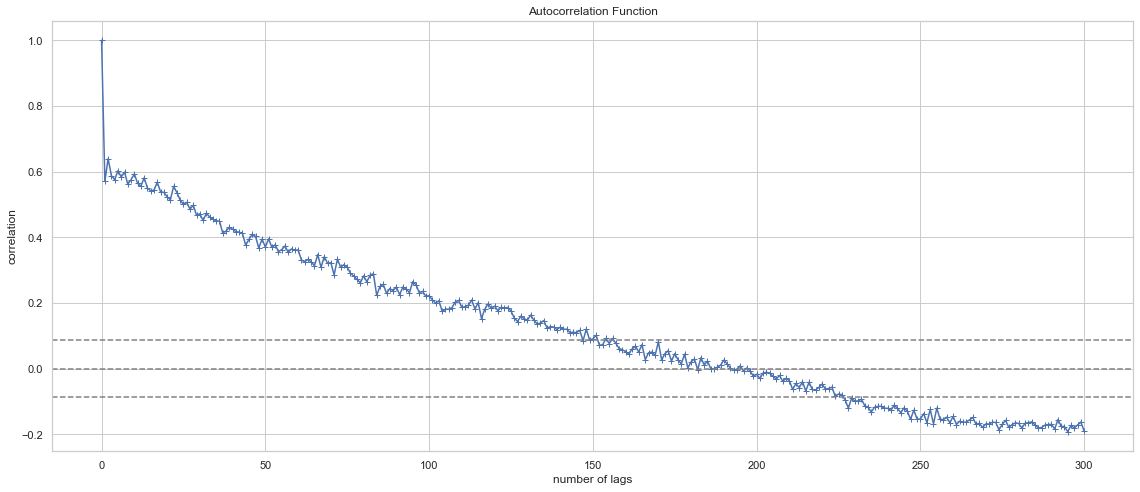

In [92]:
#calling auto correlation function
lag_acf = acf(y, nlags=300)
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In the above correlation plot dotted lines represent the confidence band, with center dotted line represents mean and upper and lower dotted line represent boundries based on 95% confidence interval.
Notice that we have good positive correlation with the lags upto 150, this is the point where ACF plot cuts the upper confidence threshold. Although we have good correlation upto 150th lag we cannot use all of them as it will create multi-collinearity problem, thats why we turn to PACF plot to get only the most relevant lags!

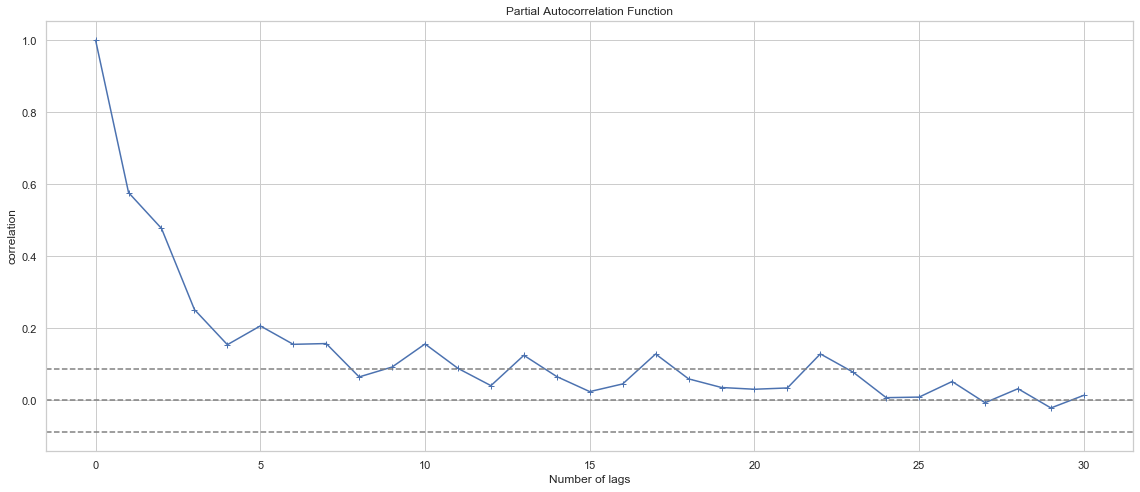

In [93]:
#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In the above plot we can see that lags upto 7 have good correlation before the plot first cuts the upper confidence interval. This is our p value i.e the order of our AR process. We can model given AR process using linear combination of first 7 lags.

Now let’s discuss the second type of process,
Moving average (MA) process, a process where the present value of series is defined as a linear combination of past errors. We assume the errors to be independently distributed with the normal distribution. The MA process of order q is defined as ,
ŷt   =   c + ϵt + θ₁ϵt-1 + θ2ϵt-2 + … + θqϵt-q

Here ϵt is a white noise. To get intuition of MA process lets consider order 1 MA process which will look like,

ŷt   =   c + ϵt + θ₁ϵt-1

let’s consider y’t as the crude oil price and ϵt is the change in the oil price due to hurricane. Assume that c=10 (mean value of crude oil price when there is no hurricane) and θ₁=0.5. Suppose, there is a hurricane today and it was not present yesterday, so y’t will be 15 assuming the change in the oil price due to hurricane as ϵt=5. Tomorrow there is no hurricane so y’t will be 12.5 as ϵt=0 and ϵt-₁=5 . Suppose there is no hurricane day after tomorrow. In that case the oil price would be 10 which means it got stabilized back to mean after getting varied by hurricane. So the effect of hurricane only stays for one lagged value in our case. Hurricane in this case is an independent phenomenon.
Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time. As we know PACF captures correlations of residuals and the time series lags, we might get good correlations for nearest lags as well as for past lags. Why would that be? Since our series is linear combination of the residuals and none of time series own lag can directly explain its present (since its not an AR), which is the essence of PACF plot as it subtracts variations already explained by earlier lags, its kind of PACF losing its power here! On the other hand being a MA process, it doesn’t have the seasonal or trend components so the ACF plot will capture the correlations due residual components only. You can also think of it as ACF which is a complete plot (capturing trend, seasonality, cyclic and residual correlations) acting as a partial plot since we don’t have trends, seasons, etc.
In the below code, I have defined a simple MA process and found its order using the ACF plot. We can expect the ACF plot to show good correlation with nearest lags and then sharp fall as its not an AR process to have good correlation with past lags. Also we would expect the PACF plot to have gradual decrease as being an MA process, nearest lag values of time series cannot really predict its present value unlike AR process.So, we will get good correlations of residuals with further lags as well, hence the gradual decrease.

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [95]:
#xma = np.random.randint(1,50000,100)
xma = np.random.normal(0,25,1000)
#lets create a MA series having mean 2 and of order 2
y5 = 2 + xma + 0.8*np.roll(xma,-1) + 0.6*np.roll(xma,-2) #+ 0.6 *np.roll(xma,-3)

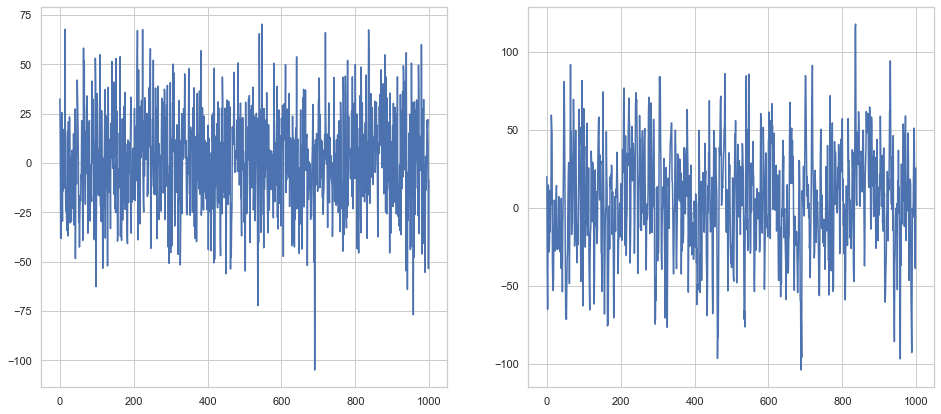

In [96]:
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.subplot(121) 
plt.plot(xma)
plt.subplot(122)
plt.plot(y5)

/Users/lcao@us.ibm.com/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


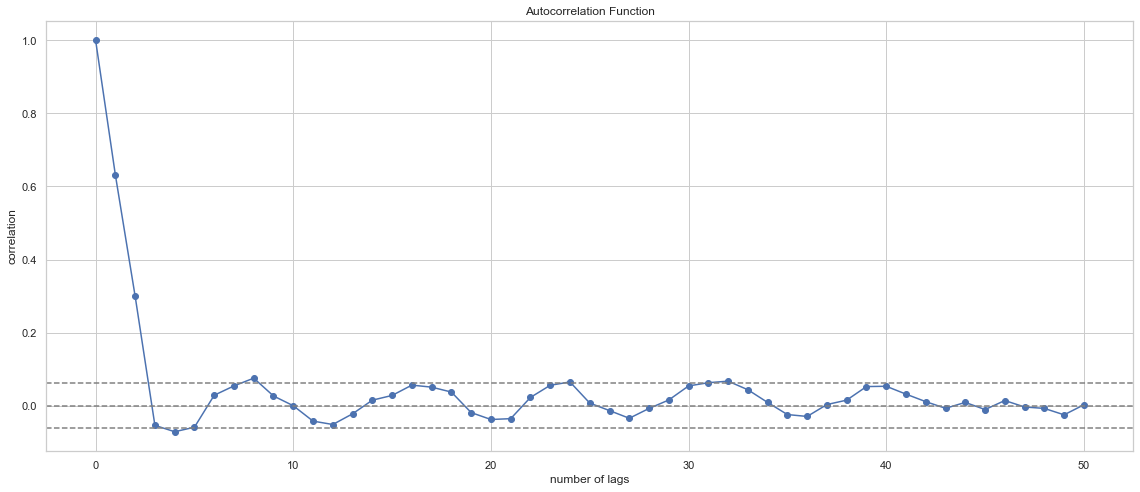

In [97]:
#calling acf function from stattools
lag_acf = acf(y5, nlags=50)
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

As per above plot we have good correlation upto 2nd lag, this is the lag after which plot cuts the upper confidence interval. Order q of series obtained by the plot is 2, which is correct as we had defined our series with linear combination of residuals upto lag 2.
Thus this proves that ACF correctly predicted order of our MA series.

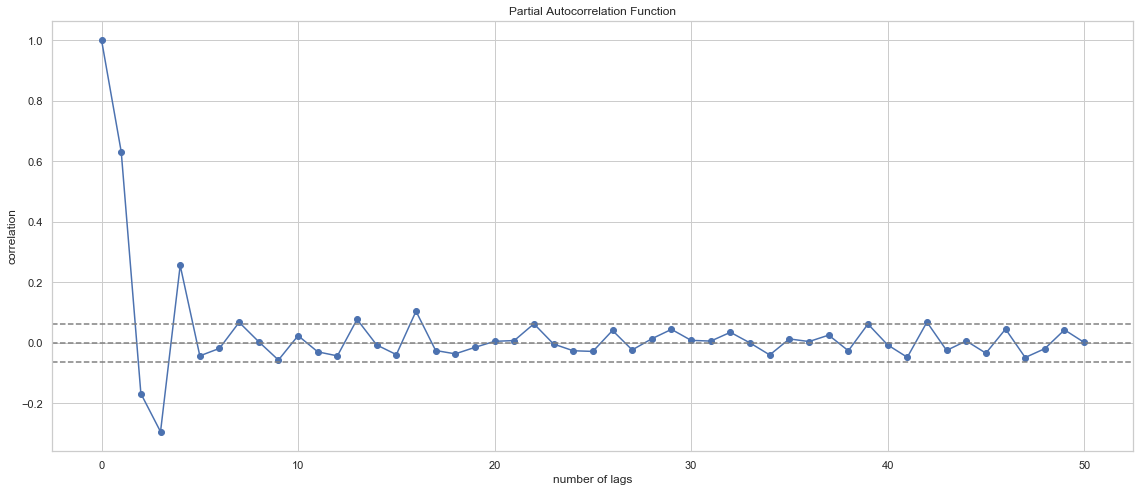

In [98]:
#calling pacf function from stattool
lag_pacf = pacf(y5, nlags=50, method='ols')

#PLOT PACF
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y5)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

If we see PACF plot there are many instances where correlation is above upper confidence band as PACF calculates correlations of lags of time series with residuals and our series itself is linear combination of residual and its lagged values.Hence we can get good correlation for near as well as past lags.

To summarize,
While building a machine learning model we should avoid multicollinear features. The same applies to time series models as well.
We find optimum features or order of the AR process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features.
We find optimum features or order of the MA process using the ACF plot, as being an MA process it doesn’t have seasonal and trend components so we get only the residual relationship with the lags of time series in the ACF plot. ACF acting as a partial plot.
I hope you liked the article, I have tried to keep it as simple as possible. As this being my first article on Medium I would really appreciate feedback and suggestions to improve myself in the future posts.

https://medium.com/@hemantranvir/spam-detection-using-rnn-simplernn-lstm-with-step-by-step-explanation-530367608071
Intuitive guide to word embedding, RNN (SimpleRNN, LSTM) with step by step implementation in keras for spam detection

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_cs("./spam_text_message_data.csv")
messages, labels = [], []
for index, row in data.iterrows():
    messages.append(row['Message'])
    if row['Category'] == 'ham':
        labels.append(0)
    else:
        labels.append(1)
        
messages = np.asarray(messages)
labels = np.asarray(labels)

In [ ]:
from keras.preprocessing.text import Tokenizer
max_vocab, max_len = 10000, 500
#Tokenizer class lets us specify the maximum number of vocabulary words to consider using num_words argument i.e keep the 10000 most frequent words, ignore the others.
tokenizer = Tokenizer(num_words=max_vocab)
#fit_on_texts method calculates the frequency of each word in our corpus/messages.
tokenizer.fit_on_texts(messages)
#texts_to_sequences method finally converts our array of sequences of strings to list of sequences of integers (most frequent word is assigned 1 and so on).
sequences = tokenizer.texts_to_sequences(messages)


In [ ]:
from keras.preprocessing.sequence import pad_sequences
#word_index attribute from Tokenizer class is a dictionary keeping track of word to their index/integer representation as calculated by fit_on_texts method.
word_index = tokenizer.word_index
#convert the list to 2D array using pad_sequences method. maxlen specifies the maximum length of sequence (truncated if longer, padded if shorter)
data = pad_sequences(sequences, maxlen=max_len)


In [ ]:
#Split the data set for training/validation and testing. 80% for training and 20% for testing.
train_samples = int(len(messages)*0.8)
messages_train = data[:train_samples]
labels_train = labels[:train_samples]
messages_test = data[train_samples:len(messages)-2]
labels_test = labels[train_samples:len(messages)-2]


In [ ]:
#build SimpleRNN in keras
import tf.keras
embedding_mat_columns = 32 #number of word vector elements
model = Sequential()
#Embedding class lets us create an word Embedding layer for the network. As discussed before it is simply a weights matrix with every row as word vector for all unique words in our vocabulary/corpus.
#input_dim argument is to specify the number of rows of the Embedding matrix.
#output_dim is to specify the number of columns of the Embedding matrix.
#input_length is to specify the maximum length of input sequence.
model.add(Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len))

#SimpleRNN class is to construct the SimpleRNN/Elman Network discussed above. units is to specify the output dimension for the SimpleRNN. The default activation for SimpleRNN is tanh.
model.add(SimpleRNN(units=embedding_mat_columns))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


In [ ]:
#Train the model
model.fit(messages_train, labels_train, epochs=10, batch_size=60, validation_split=0.2)
acc = model.evaluate(messages_test, labels_test)
print("Test loss is {0:.2f} accuracy is {1:.2f} ".format(acc[0], acc[1]))
#Test loss is 0.11 accuracy is 0.96

In [ ]:
#give it a custom message and check the prediction:
def message_to_array(msg):
    msg = msg.lower().split(' ')
    test_seq = np.array([word_index[word] for word in msg])
    test_seq = np.pad(test_seq, (500-len(test_seq), 0),
                      'constant', constant_values=(0))
    test_seq = test_seq.reshape(1, 500)
    return test_seq
custom_msg = 'Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed Free entry for movies'
test_seq = message_to_array(custom_msg)
pred = model.predict_classes(test_seq)
print(pred)
#[[1]]  #where 1 means it is spam. Hence the model seems to be working!

X 1,t … X m,t is input vector of size m at time instant t
H 1,t … H n,t is output vector of size n at time instant t
H 1,t-1 … H n,t-1 is output vector of size n at time instant t-1
Here we are feeding the output of the hidden layer back to itself after one timestep delay.
The input vector we are referring here is basically just the word vector. Hence we will be feeding the network one word vector at a time. Since we have at max 500 words in our each message, we will feeding 500 word vectors to the above model.
Each element of the input vector ( 32 elements in one word vector) is connected to each node in the output layer (output dimension of SimpleRNN). If we consider word vector of size m and output dimension of size n. Then there are mxn weights to connect the input vector to output nodes.
Also the output of previous timestep is also connected to the output nodes. Each element of the output vector (total n elements) of previous time step is connected to every element of the output vector of current time step. Thus there are nxn weights. (I have shown all connections for H 1, t-1 only for simplicity)
Finally we have n number of biases (simply adding the value).
Hence in total we have following number of trainable parameters:
(n*m + n*n + n) = total trainable parameters in SimpleRNN

Now in LSTM instead of one such fully connected recurrent network we have four. Specifically (in Figure SimpleRNN compact) the tanh block denotes 2 weight matrices of size nxn and nxm each and a bias vector of size n. In LSTM we will have four such FFNNs. Each of these four FFNNs have their own 2 weight matrices (of size nxm and nxn each) and a bias vector of size n. Hence the total number of trainable parameters for LSTM would be:
4*(n*m + n*n + n) = LSTM trainable parameters (with bias)
The connections diagram for LSTM with all nodes would be too complex to draw but having grasped SimpleRNN, one can imagine there are four SimpleRNN structures (three with sigmoid activation and one with tanh) at the input of LSTM.

In [ ]:
#build the LSTM network in keras
model.add(LSTM(units=embedding_mat_columns)
#We just need to replace SimpleRNN class with LSTM class in the previous code snippets, everything else remains the same.
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
model.fit(messages_train, labels_train, epochs=10, batch_size=60, validation_split=0.2)
acc = model.evaluate(messages_test, labels_test)
print("Test loss is {0:.2f} accuracy is {1:.2f} ".format(acc[0], acc[1]))
#Test loss is 0.06 accuracy is 0.99